# Getting Started - Installation and Imports

In [1]:
!curl -O https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth #for Linux: wget {Link}
%pip install 'git+https://github.com/facebookresearch/segment-anything.git'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2445M  100 2445M    0     0  11.7M      0  0:03:27  0:03:27 --:--:-- 11.7M     0  11.8M      0  0:03:26  0:00:12  0:03:14 12.0M 0:03:10 11.5M 669M    0     0  11.8M      0  0:03:26  0:00:56  0:02:30 12.1M    0  11.8M      0  0:03:25  0:01:14  0:02:11 12.1M9M    0     0  11.8M      0  0:03:25  0:01:16  0:02:09 12.0M     0  11.9M      0  0:03:25  0:01:18  0:02:07 12.1M 0  11.9M      0  0:03:25  0:01:25  0:02:00 11.9M    0  11.9M      0  0:03:24  0:01:42  0:01:42 12.1M  11.7M      0  0:03:27  0:02:48  0:00:39 12.1M4M    0     0  11.7M      0  0:03:27  0:03:01  0:00:26 11.3M03:27  0:03:15  0:00:12 11.6M
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/tt/plrj7c_x5c769tsqdqgf30w40000gn/T/pip-req-build-6adt5hp9
  Running command git clone --filter=blob:none --quiet https://github.com/faceboo

In [3]:
import cv2
import numpy as np
#Load the model
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## Helper functions from [SAM Gitlab](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)

In [1]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Define Image

In [6]:
# Define image path here
IMAGE_PATH = 'test_image.jpeg'


# Generate Image Embedding

In [7]:
# Automated Mask (Instance Segmentation) Generation with SAM

try:
    image_bgr = cv2.imread(IMAGE_PATH)
    if image_bgr is not None:
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    else:
        print("Failed to load the image.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


In [8]:
print(image_rgb.shape)

(400, 800, 3)


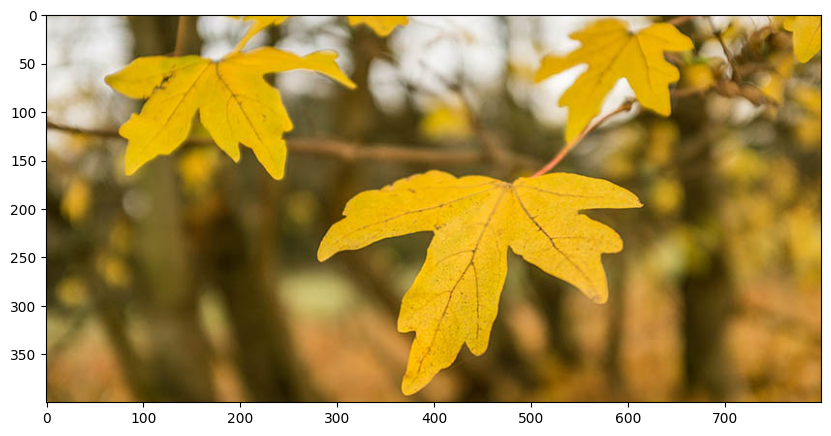

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()

In [10]:
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)#.set_image gives the predictor the image and the embedding gets calculated


In [11]:
image_embedding = predictor.get_image_embedding()
image_embedding.shape

torch.Size([1, 256, 64, 64])

In [12]:
image_embedding

tensor([[[[-7.7264e-02, -4.7009e-02, -1.4762e-02,  ...,  8.8254e-02,
            1.6098e-01,  1.9439e-01],
          [-8.5107e-02, -6.0811e-02, -2.6220e-02,  ...,  8.5560e-02,
            8.3987e-02,  1.2877e-01],
          [-1.3545e-01, -1.0398e-01, -4.7767e-02,  ...,  6.3237e-02,
            5.8836e-02,  1.0921e-01],
          ...,
          [-4.7489e-02, -7.0232e-02, -6.7062e-02,  ..., -1.1782e-01,
           -1.1621e-01, -1.2516e-01],
          [-5.5104e-02, -7.3877e-02, -6.9942e-02,  ..., -1.1385e-01,
           -1.1392e-01, -1.2129e-01],
          [-7.9370e-02, -8.6354e-02, -8.5396e-02,  ..., -1.0037e-01,
           -9.7945e-02, -9.3643e-02]],

         [[-2.9071e-02, -3.2802e-02, -4.1672e-02,  ..., -4.5138e-02,
            2.2782e-02,  2.7911e-02],
          [-1.2579e-01, -1.5279e-01, -1.7366e-01,  ...,  5.2261e-02,
            5.0609e-02,  8.9927e-02],
          [-1.0306e-01, -1.3106e-01, -1.4920e-01,  ...,  4.0989e-03,
            9.5673e-02,  8.2195e-02],
          ...,
     

# Creating a point prompt

In [13]:
input_point = np.array([[400, 200]]) #coordinates of the input point
input_label = np.array([1]) # type of input point (1: forground; 0: background)

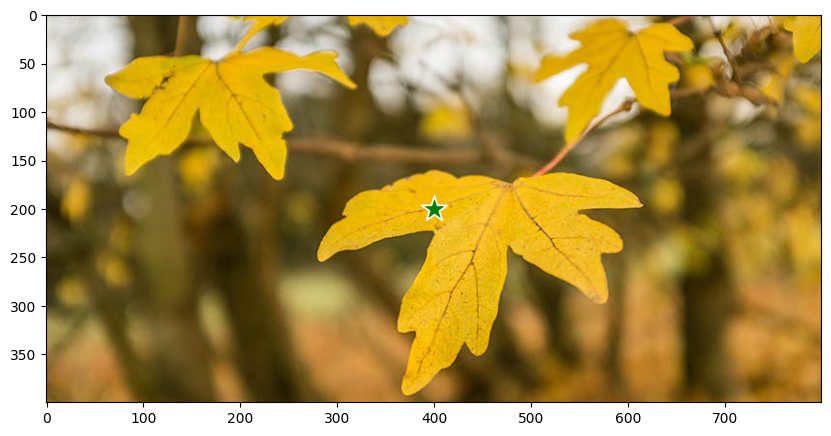

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [15]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [16]:
masks.shape  # (number_of_masks) x H x W

(3, 400, 800)

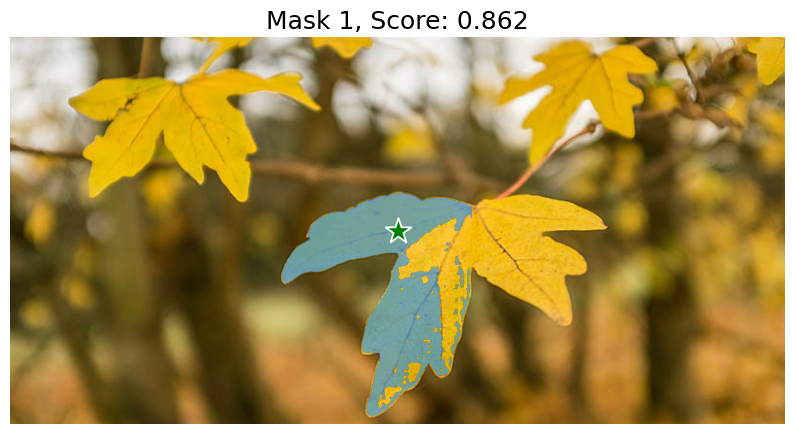

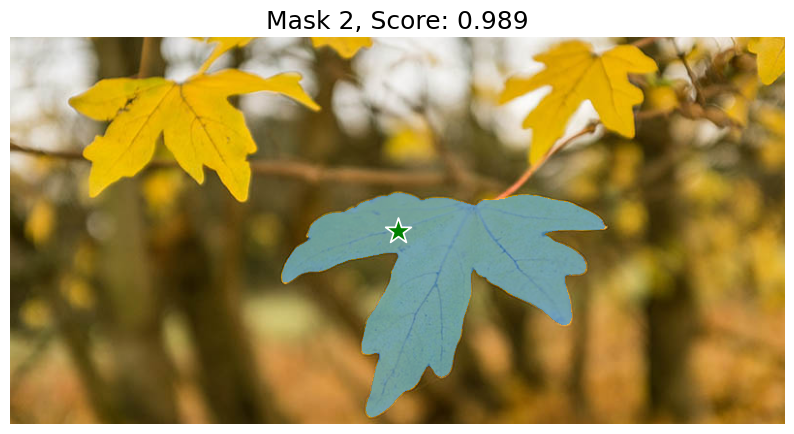

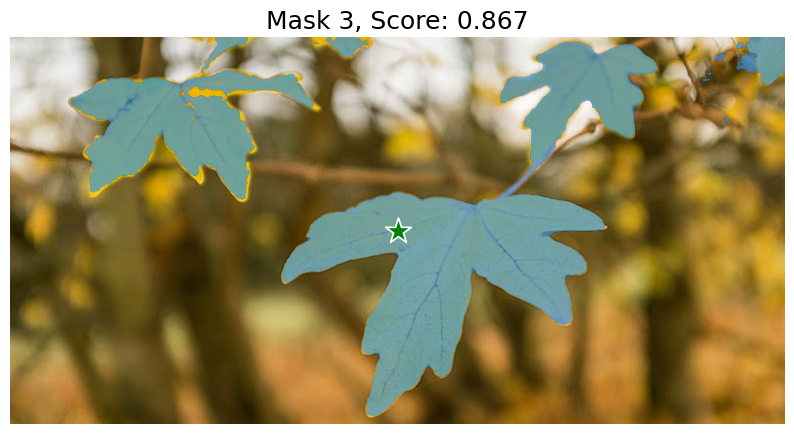

In [17]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_rgb)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

# Creating a bounding box prompt

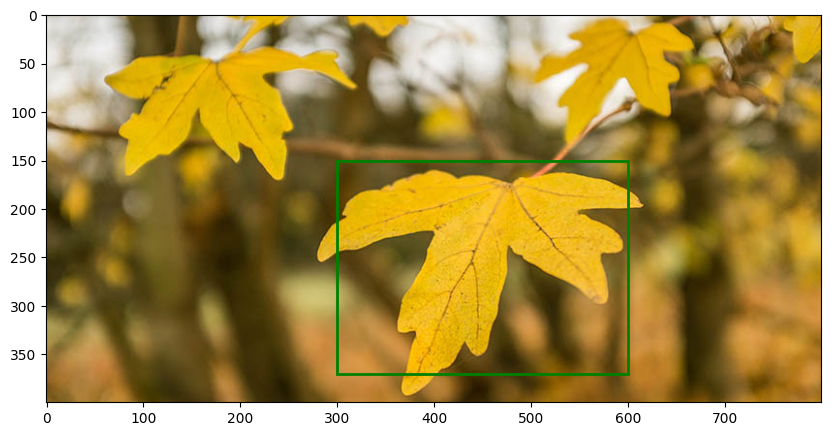

In [18]:
input_box = np.array([300, 150, 600, 370])#(x_upper_left,y_upper_left,y_lower_right,y_lower_right)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [19]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

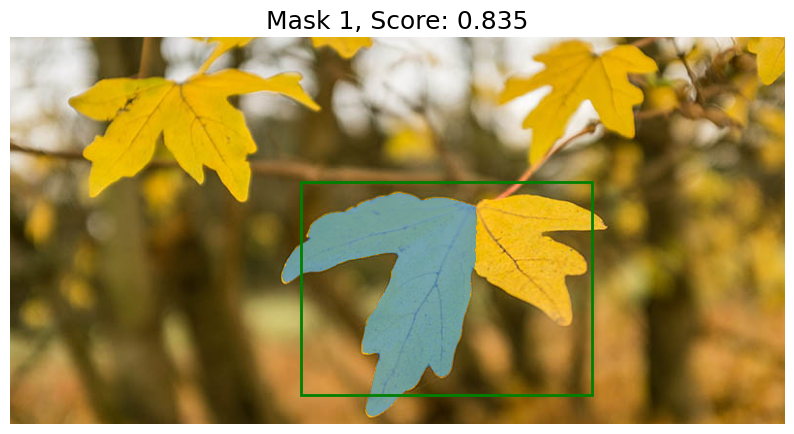

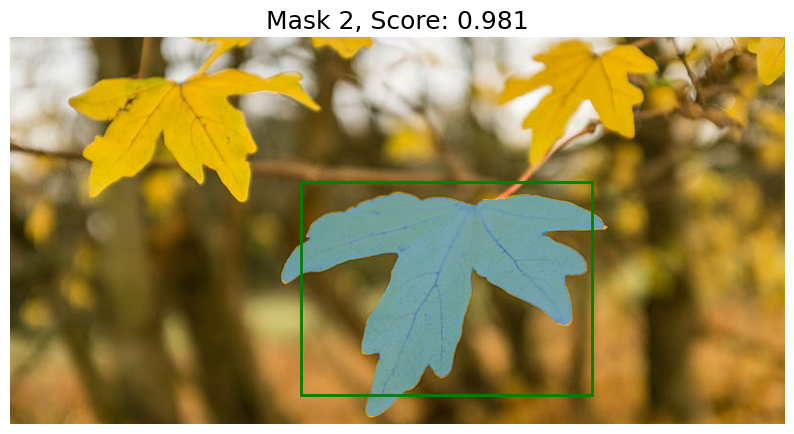

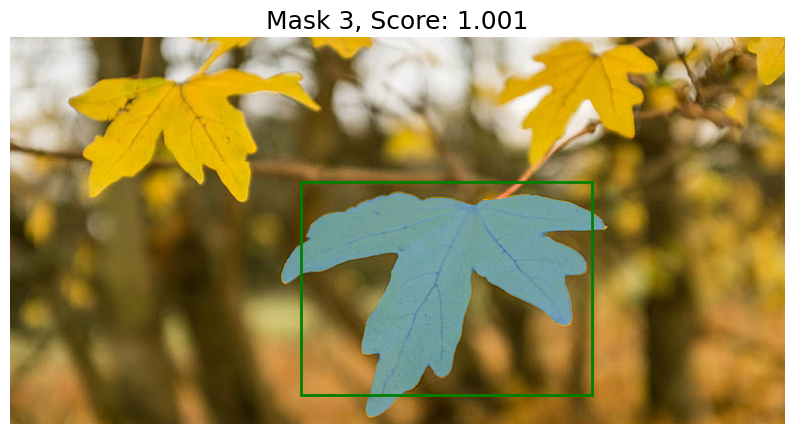

In [20]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image_rgb)
    show_mask(mask, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  


# Automatic Mask Generation

In [21]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [22]:
masks = mask_generator.generate(image_rgb)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- segmentation : the mask
- area : the area of the mask in pixels
- bbox : the boundary box of the mask in XYWH format
- predicted_iou : the model's own prediction for the quality of the mask
- point_coords : the sampled input point that generated this mask
- stability_score : an additional measure of mask quality
- crop_box : the crop of the image used to generate this mask in XYWH format

In [23]:
print(len(masks))

88


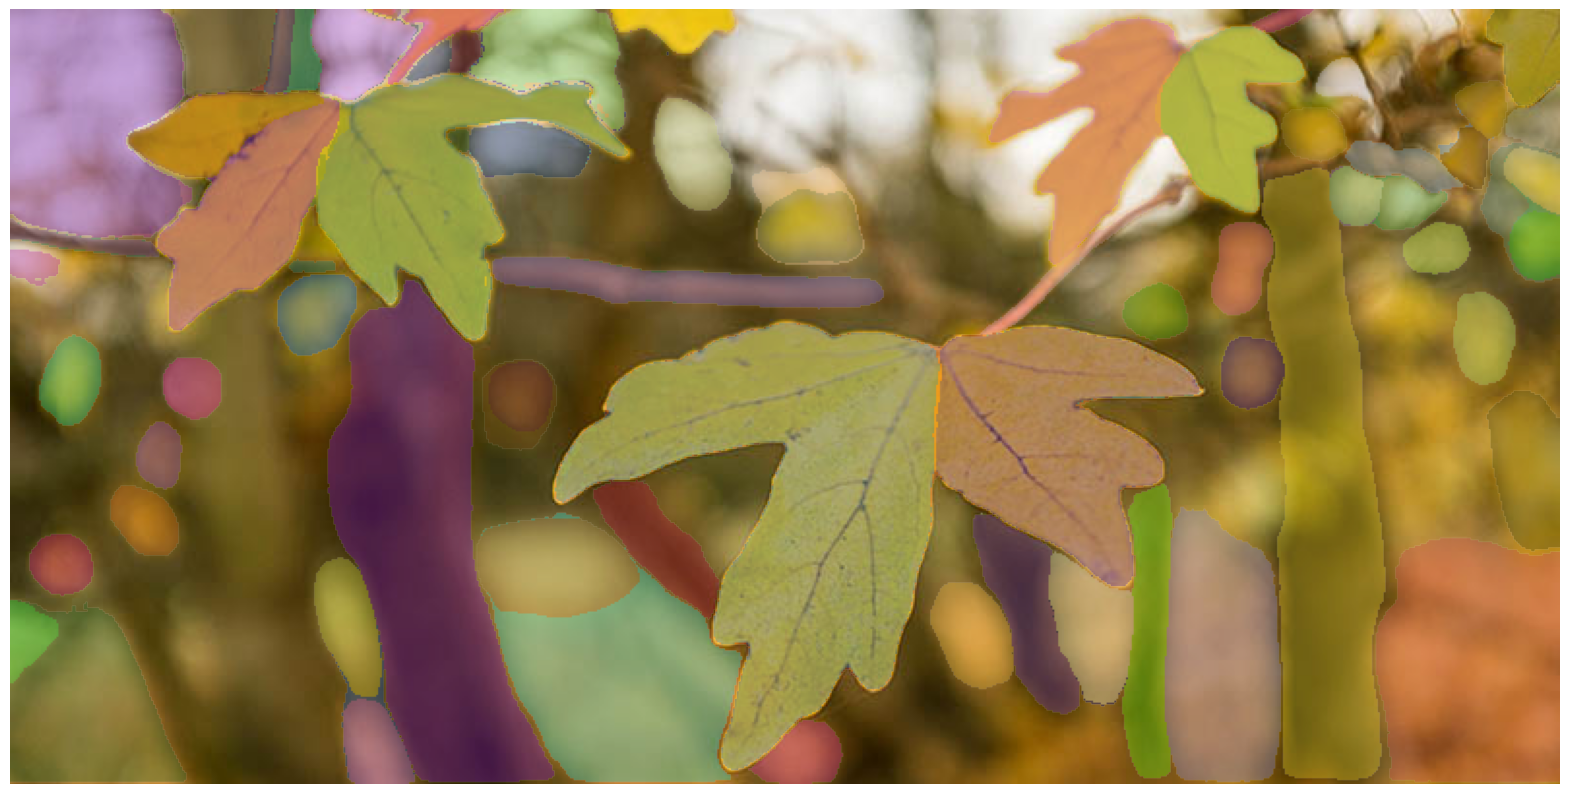

In [25]:
plt.figure(figsize=(20,20))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 